# Learning Goals

In Assignment 1, we studied how information is represented by a single spiking neuron. In this assignment, you will learn how to construct networks of spiking neurons for a given cognitive task, how to propagate information through a network, and understanding the intuition behind network design choices. 

Let's first import all the libraries required for this assignment

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Question 1: From single neuron to network of neurons
## 1a.
What computational advantages do networks of neurons offer when compared against information processing by a single neuron? In other words, why do we need networks of neurons? 

## Answer 1a.
Neural networks can process more complex information than a single neuron. Neural network can perform multiple tasks in parallel without affecting the system performance, and it is more efficient to send and receive information. Also, if a neuron is not responding, the network can still produce the output.

## 1b. 
Describe the algorithm for the information flow through a network of spiking leaky-integrate-and-fire (LIF) neurons. Specifically, trace out the steps required to compute network output from a given (continuous-valued) inputs. The algorithm should describe how continuous-valued inputs are fed to the SNN input layer, how the layer activations are computed, and how the output layer activity is decoded. Also, provide a diagrammatic overview of the algorithm to aid your explanation. You are free to assume any network size, and input and output dimensions. 

## Answer 1b.
1. Using an image input as an example to show how to convert continuous values into pulses:
    I.For each pixel in the image, sample a random number.
    II.If the pixel intensity is greater than the generated random number, output a spike.
    III.Repeat for as many timesteps as you need to encode the image for.
    IV.Repeat for all pixels
In this example, the pixels are continuous values, and multiple random sampling outputs are pulses.


2. For each LIF neural layer, compute its output:
    V(t) = V(t-1) * vdecay + input_spike(t)
    if V(t) > vth, output_spike(t) = 1, V(t) = Reset


3. The input layer convert input images into spike trains. Poisson neuron are used in this layer. The spikes generated are transmitted to the synapses in the middle. The synapses modulate the recieved spikes by their weights and pass them to the output layer. LIF neurons in the output layer process the spikes and generate output spikes. The output spikes are passed back to corresponding synapses and tune the synapse weights via STDP rule. Also, the output spikes are broadcasted among output neurons through the lateral inhibition paths, allowing competition during learning.


4. After all time series calculations are completed, the accumulated results are output.

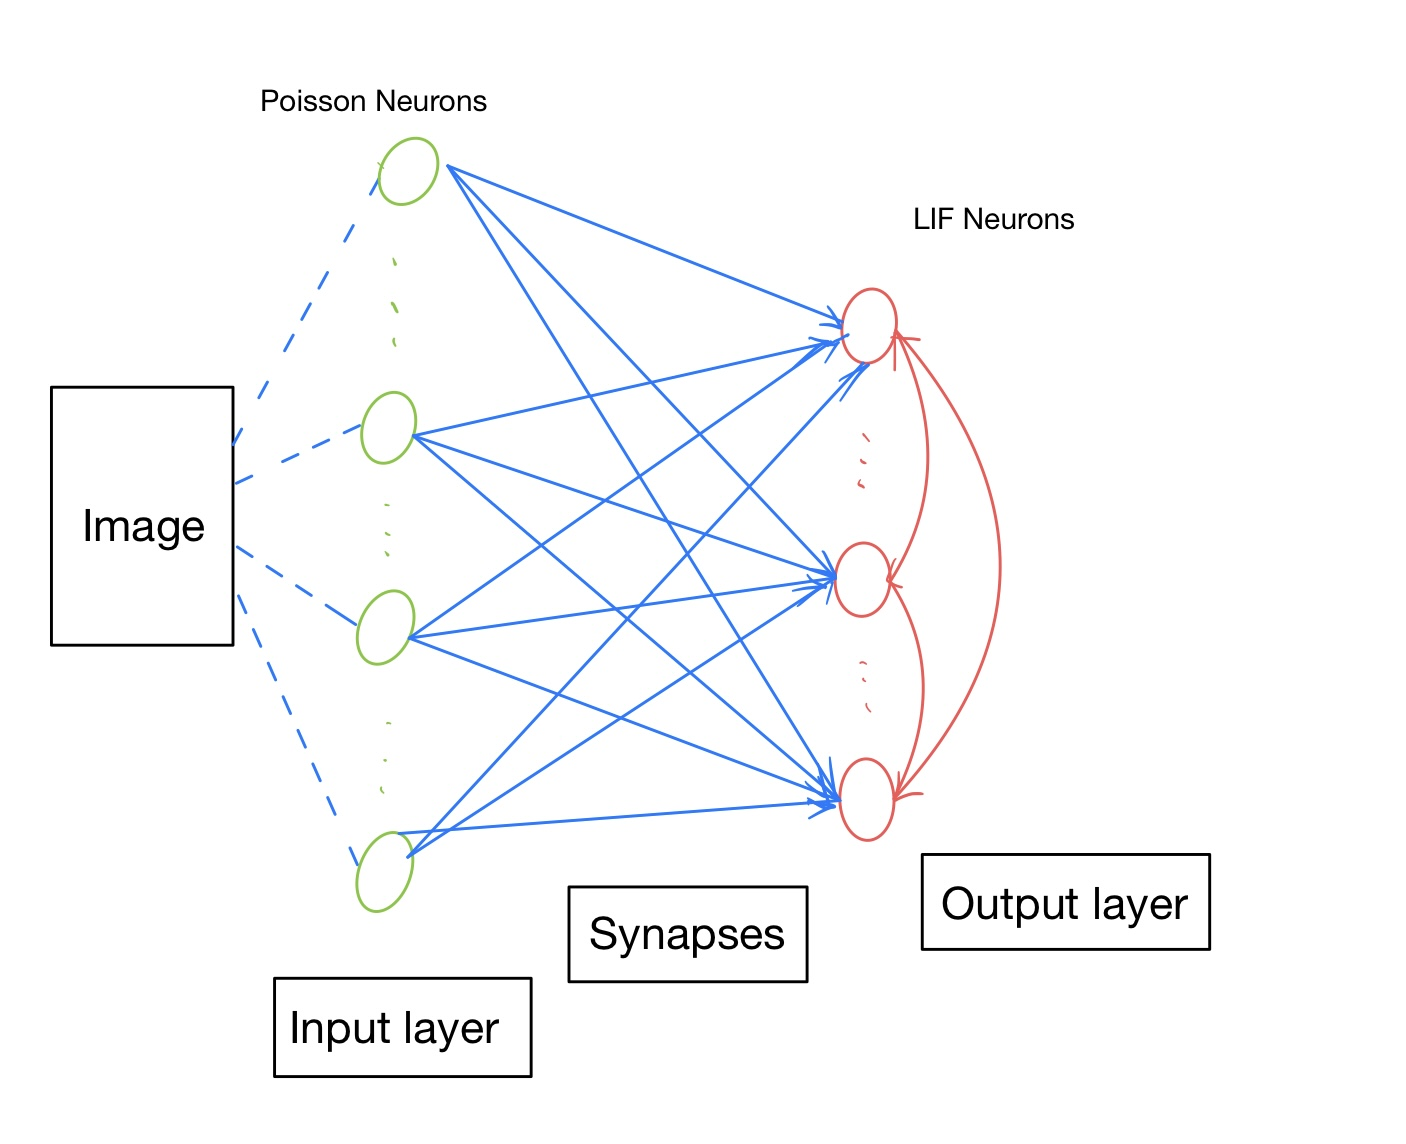

# Question 2: Elements of Constructing Feedforward Networks
In this exercise, you will implement the two fundamental components of a feedforward spiking neural network: i) layers of neurons and ii) connections between those layers
## 2a. 
As the first step towards creating an SNN, we will create a class that defines a layer of LIF neurons. The layer object creates a collection of LIF neurons and applies input current to it (also called psp_input for postsynaptic input) to produce the collective spiking output of the layer.

Below is the class definition for a layer of LIFNeurons. Fill in the components to define the layer. 

In [2]:
class LIFNeurons:
    """ Define Leaky Integrate-and-Fire Neuron Layer """

    def __init__(self, dimension, vdecay, vth):
        """
        Args:
            dimension (int): Number of LIF neurons in the layer
            vdecay (float): voltage decay of LIF neurons
            vth (float): voltage threshold of LIF neurons
        
        This function is complete. You do not need to do anything here.
        """
        self.dimension = dimension
        self.vdecay = vdecay
        self.vth = vth

        # Initialize LIF neuron states
        self.volt = np.zeros(self.dimension)
        self.spike = np.zeros(self.dimension)
    def __call__(self, psp_input):
        """
        Args:
            psp_input (ndarray): synaptic input current at a single timestep. The shape of this is same as the number of neurons in the layer. 
        Return:
            self.spike: output spikes from the layer. The shape of this should be the same as the number of neurons in the layer. 
        
        Write the expressions for updating the voltage and generating the spikes for the layer given psp_input at one timestep. 
        """
        #Update the voltage
        volt_last = np.copy(self.volt)
        self.volt = volt_last * self.vdecay + psp_input
        
        #Generate the spikes from the voltage
        self.spike[self.volt >= self.vth] = 1
        self.spike[self.volt < self.vth] = 0
        
        #Reset the voltage if the neuron spikes
        self.volt[self.volt >= self.vth] = 0
        
        return self.spike

To verify the correctness of your class implementation, create a layer of neurons using the class definition above, and pass through it random inputs. 

In [3]:
#Create a layer of neurons using the class definition above. You can pick any parameter values for the neurons. 
LIFNeurons_example = LIFNeurons(dimension=10, vdecay=0.5, vth=0.5)

#Create random input spikes with any probability and print them. Numpy random.choice function might be useful here. 
psp_input_random = np.random.choice(2, 10)
print(psp_input_random)

#Propagate the random input spikes through the layer and print the output
spike_result = LIFNeurons_example(psp_input_random)
print(spike_result)



[1 1 0 0 0 1 1 1 0 0]
[1. 1. 0. 0. 0. 1. 1. 1. 0. 0.]


## 2b.
Now, we will create a class the defines the connection between a presynaptic layer and a postsynaptic layer. To create the connection, we need the activity of the presynaptic layer (also called presynaptic layer activation) and the weight matrix connecting the presynaptic and postsynaptic neurons. The output of the class should be the current for the postsynaptic layer. 

Below is the class definition for Connections. Fill in the components to create the connections. 

In [4]:
class Connections:
    """ Define connections between spiking neuron layers """

    def __init__(self, weights, pre_dimension, post_dimension):
        """
        Args:
            pre_dimension (int): number of neurons in the presynaptic layer
            post_dimension (int): number of neurons in the postsynaptic layer
            weights (ndarray): connection weights of shape post_dimension x pre_dimension

        This function is complete. You do not need to do anything here.

        """
        self.weights = weights
        self.pre_dimension = pre_dimension
        self.post_dimension = post_dimension
    
    def __call__(self, spike_input):
        """
        Args:
            spike_input (ndarray): spikes generated by the pre-synaptic neurons
        Return:
            psp: current for the post-synaptic neurons
        
        Write the operation for computing psp
        """
        
        #Compute psp given spike_input and self.weights
        [m, n] = np.shape(self.weights)
        if(m != self.post_dimension or n != self.pre_dimension):
            print("Weight matrix input error!")
            return False
        spike_input = np.reshape(spike_input, (self.pre_dimension, 1))
        psp =  np.dot( self.weights, spike_input)
        psp = psp.flatten()
        return psp

To verify the correctness of your class implementation, create a connection object and compute the postsynaptic current for random presynaptic activation inputs and random connection weights. You can pick arbitrary values for class arguments. 

In [5]:
#Define the dimensions of the presynaptic layer in a variable
pre_dimension = 10

#Define the dimensions of the postsynaptic layer in a variable
post_dimension = 5

#Create random presynaptic inputs with any probability. Numpy random choice function might be useful here. 
presynaptic_inputs = np.random.choice(2, 10)
print(presynaptic_inputs)

#Create a random connection weight matrix. Numpy random rand function might be useful here. 
weight_matrix = np.random.rand(post_dimension, pre_dimension)
print(weight_matrix)

#Initialize a connection object using the Connection class definition and pass the variables created above as arguments
Connections_example = Connections(weight_matrix, pre_dimension, post_dimension)

#Compute the current for the postsynaptic layer when the connection object is fed random presynaptic activation inputs
current_result = Connections_example(presynaptic_inputs)

#Print the shape of the current
print(current_result)


[0 1 1 0 1 1 0 1 0 0]
[[9.92685263e-01 1.43680321e-01 2.90300267e-01 5.18192356e-01
  6.27133012e-01 2.89683149e-01 7.13093463e-01 2.26622468e-01
  9.81804897e-01 5.21022341e-01]
 [3.63128450e-01 9.81780279e-01 4.16460136e-01 9.15776722e-01
  1.72342208e-01 8.31573132e-01 8.87497054e-01 9.27802417e-02
  1.30320488e-01 3.52203518e-01]
 [6.31607116e-01 5.62457785e-02 2.14186504e-01 2.56288252e-01
  9.80039293e-01 1.62594930e-01 7.82437545e-01 6.12583148e-01
  3.55409881e-01 5.81110740e-01]
 [7.04382037e-01 9.68280729e-04 9.82841291e-01 3.14020072e-01
  2.02879236e-01 4.64982113e-01 8.40080032e-01 4.33149819e-01
  1.47758479e-01 5.67312119e-01]
 [8.25699756e-01 4.94786679e-01 6.45445628e-01 5.58386760e-01
  2.32328647e-02 3.74869467e-01 7.54051222e-01 6.37538331e-01
  8.90730943e-01 4.78363967e-01]]
[1.57741922 2.494936   2.02564965 2.08482074 2.17587297]


# Question 3: Constructing Feedforward SNN
Now that you have implemented the basic elements of an SNN- layer and connection, you are all set to implement a fully functioning SNN. The SNN that you will implement here consists of an input layer, a hidden layer, and an output layer. 

Below is the class definition of an SNN. Your task is to create the layers and connections that form the network using the class definitions in Question 2. Then complete the function to propagate a given input through the network and decode network output. 

In [6]:
class SNN:
    """ Define a Spiking Neural Network with One Hidden Layer """

    def __init__(self, input_2_hidden_weight, hidden_2_output_weight, 
                 input_dimension=784, hidden_dimension=256, output_dimension=10,
                 vdecay=0.5, vth=0.5, snn_timestep=20):
        """
        Args:
            input_2_hidden_weight (ndarray): weights for connection between input and hidden layer. dimension should be hidden_dimension x input_dimension. 
            hidden_2_output_weight (ndarray): weights for connection between hidden and output layer. dimension should be output dimension x hidden dimension. 
            input_dimension (int): number of neurons in the input layer
            hidden_dimension (int): number of neurons in the hidden layer
            output_dimension (int): number of neurons in the output layer
            vdecay (float): voltage decay of LIF neurons
            vth (float): voltage threshold of LIF neurons
            snn_timestep (int): number of timesteps for simulating the network (also called inference timesteps)
        """
        self.snn_timestep = snn_timestep
        
        #Create the hidden layer
        self.hidden_layer = LIFNeurons(dimension=hidden_dimension, vdecay=vdecay, vth=vth)
        
        #Create the output layer
        self.output_layer = LIFNeurons(dimension=output_dimension, vdecay=vdecay, vth=vth)
        
        #Create the connection between input and hidden layer
        self.Connction_1 = Connections(input_2_hidden_weight, input_dimension, hidden_dimension)
        
        #Create the connection between hidden and output layer
        self.Connction_2 = Connections(hidden_2_output_weight, hidden_dimension, output_dimension)
        
    
    def __call__(self, spike_encoding):
        """
        Args:
            spike_encoding (ndarray): spike encoding of input
        Return:
            output: decoded output from the network
        """
        
        #Initialize an array to store the decoded network output for all neurons in the output layer
        spike_output = np.zeros(self.output_layer.dimension)
        
        #Loop through the simulation timesteps and process the input at each timestep tt
        for tt in range(self.snn_timestep):
            
            #Propagate the input through the input  hidden layer and compute current for hidden layer
            spike_input = spike_encoding[:, tt]
            spike_input = spike_input.flatten()
            input_current_hidden_layer = self.Connction_1(spike_input)

            #Compute hidden layer spikes 
            output_current_hidden_layer = self.hidden_layer(input_current_hidden_layer)

            #Propagate hidden layer inputs to output layer and compute current for output layer
            input_current_output_layer = self.Connction_2(output_current_hidden_layer)   
            
            #compute output layer spikes
            output_layer_spikes = self.output_layer(input_current_output_layer)
            
            #Decode spike outputs by summing them up
            spike_output = spike_output + output_layer_spikes
            
        return spike_output

To verify the correctness of your class implementation, define the arguments to initialize the SNN. Then initialize the SNN and pass through it random inputs and compute network outputs. You can pick arbitrary values for class arguments. 

In [7]:
#Define the dimensions of the input layer in a variable
input_layer_dimensions = 784

#Define the dimensions of the hidden layer in a variable
hidden_layer_dimensions = 256

#Define the dimensions of the output layer in a variable
output_layer_dimensions = 10

#Define vdecay in a variable
vdecay = 0.5

#Define vth in a variable
vth = 130

#Define snn_timesteps in a variable
snn_timesteps = 20

#Create random input to hidden layer weights. Numpy random rand function might be useful here
hidden_layer_weigth = np.random.rand(hidden_layer_dimensions, input_layer_dimensions)

#Create random hidden to output layer weights. Numpy random rand function might be useful here
output_layer_weight = np.random.rand(output_layer_dimensions, hidden_layer_dimensions)

#Create random spike inputs to the network. Numpy random choice function might be useful here
spike_inputs = np.random.choice(2, (input_layer_dimensions, snn_timesteps))

#Print the inputs
print(spike_inputs)

#Create an SNN object using the class definition and variables defined above
SNN_example = SNN(hidden_layer_weigth, output_layer_weight, 
                 input_dimension=input_layer_dimensions, hidden_dimension=hidden_layer_dimensions, output_dimension=output_layer_dimensions,
                 vdecay=vdecay, vth=vth, snn_timestep=snn_timesteps)

#Pass the random spike inputs through the SNN and print the output of the SNN
output = SNN_example(spike_inputs)
print(output)


[[1 0 0 ... 0 1 1]
 [0 1 1 ... 0 1 0]
 [1 0 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [1 0 0 ... 1 1 0]]
[10. 20. 20. 20. 10. 10. 10. 10. 10. 10.]


# Question 4: SNN for Classification of Digits
So far we have learnt how to construct SNNs for random inputs. In this exercise, you will use your implementation of SNNs to classify real-world data, taking the dataset of handwritten digits as an example. The dataset is provided as numpy arrays in the folder "data". Each sample in the MNIST dataset is a 28x28 image of a digit and a label (between 0 and 9) of that image. We will be dealing with batches, which means that we will read a fixed number of samples from the dataset (also called the batch size).

## 4a. 
First, we need to write two helper functions- to read the data from the saved data files, and to convert an image into spikes. The function to read the data is already written for you. You need to complete the function for encoding the data into spikes. 

In [8]:
def read_numpy_mnist_data(save_root, num_sample):
    """
    Read saved numpy MNIST data
    Args:
        save_root (str): path to the folder where the MNIST data is saved
        num_sample (int): number of samples to read
    Returns:
        image_list: list of MNIST image
        label_list: list of corresponding labels
    
    This function is complete. You do not need to do anything here.
    """
    image_list = np.zeros((num_sample, 28, 28))
    label_list = []
    for ii in range(num_sample):
        image_label = pickle.load(open(save_root + '/' + str(ii) + '.p', 'rb'))
        image_list[ii] = image_label[0]
        label_list.append(image_label[1])

    return image_list, label_list

def img_2_event_img(image, snn_timestep):
    """
    Transform image to spikes, also called an event image
    Args:
        image (ndarray): image of shape batch_size x 28 x 28
        snn_timestep (int): spike timestep
    Returns:
        event_image: event image- spike encoding of the image
        
    Complete the expression for converting the image to spikes (event image)
    """
    
    #Reshape the image. Do not touch this code
    batch_size = image.shape[0]
    image_size = image.shape[2]
    image = image.reshape(batch_size, image_size, image_size, 1)
    
    #Generate a random image of the shape batch_size x image_size x image_size x snn_timestep. Numpy random rand function will be useful here. 
    random_image  = np.random.rand(batch_size, image_size, image_size, snn_timestep)
    
    #Generate the event image
    event_image = np.zeros((batch_size, image_size, image_size, snn_timestep))
    for i in range(snn_timestep):
        sample_matrix = random_image[:,:,:,i]
        event_image[:,:,:,i] = np.subtract(image[:,:,:,0], sample_matrix)
    event_image[event_image >= 0] = 1
    event_image[event_image < 0] = 0
    return event_image

To verify the correctness of your class implementation, load a sample digit from the saved file and convert it into an event image. Then print the shape of the event image. 

(1000, 28, 28)
(1000, 28, 28, 20)


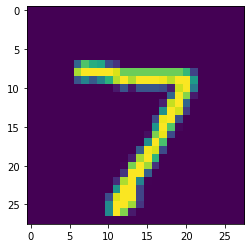

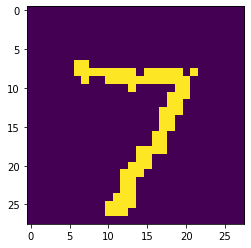

In [10]:
#Load 1000 samples from the MNIST dataset using the read function defined above
save_root = "/Users/shuhanshi/Desktop/Assignment2_answer/Assignment2/data/mnist_test"
image_list, label_list = read_numpy_mnist_data(save_root, 1000)
plt.figure()
plt.imshow(image_list[0,:,:])

#Print the shape of the data
print(image_list.shape)

#Convert the images to event images
event_image_list = img_2_event_img(image_list, 20)
plt.figure()
plt.imshow(event_image_list[0,:,:,0])

print(event_image_list.shape)


## 4b. 
Next, we need another helper function to compute the classification accuracy of the network. The classification accuracy is defined as the percentage of the samples that the network classifies correctly. To compute the classification accuracy, you need to:

- Propagate each input through the network and obtain the network output.
- Based on the network output, the class of the image is the one for which the output neuron has maximum value. Let's call this predicted class. 
- Compare the predicted class against the true class. 
- Compute accuracy as the percentage of correct predictions. 

Below is the function for computing the test accuracy. The function takes in as arguments the SNN, directory in which the MNIST data is saved, and the number of samples to take from the MNIST dataset. Your task is to use the helper functions created above to load the data, convert into event images, and then compute network prediction and accuracies. 

In [11]:
def test_snn_with_mnist(network, data_save_dir, data_sample_num):
    """
    Test SNN with MNIST test data
    Args:
        network (SNN): defined SNN network
        data_save_dir (str): directory for the test data
        data_sample_num (int): number of test data examples
    """
    #Read image and labels using the read function
    test_image_list, test_label_list = read_numpy_mnist_data(data_save_dir, data_sample_num)
    
    #Convert the images to event images
    event_image_list = img_2_event_img(test_image_list, network.snn_timestep)
    
    #Initialize number of correct predictions to 0
    correct_prediction = 0
    
    #Loop through the test images
    for i in range(data_sample_num):
        #Compute network output for each image. You might have to reshape the image using Numpy reshape function so that its appropriate for the SNN
        event_image = event_image_list[i,:,:,:]
        event_image = event_image.reshape(784, network.snn_timestep)
        
        #Determine the class of the image from the network output. Numpy argmax function might be useful here
        result = network(event_image)
        result_class = np.argmax(result)
        
        #Compare the predicted class against true class and update correct_prediction counter
        if result_class == test_label_list[i]:
            correct_prediction = correct_prediction + 1

    #Compute test accuracy
    test_accuracy = correct_prediction / data_sample_num
    
    return test_accuracy

# Question 5: Tuning Membrane Properties for Correct Classification 
Great! We have everything that we need to measure the performance of the SNN for classification of MNIST digits. For this, we first need to create the SNN using the class definition we wrote in Q.3. Then we need to call the test function that we wrote in Q.4b. However, note that the SNN needs the connection weights between the layers as inputs. These weights are typically obtained as a result of "training" the network for a given task (such as MNIST classification). However, since training the network isn't a part of this assignment, we provide to you already trained weights. 

## 5a. 
Your task in this exercise is to initialize an SNN with vdecay=1.0 and vth=0.5. Test the SNN on MNIST dataset and obtain the classification accuracy.  

In [16]:
#Load the weights. Do not touch this code
snn_param_dir = '/Users/shuhanshi/Desktop/Assignment2_answer/Assignment2/save_models/snn_bptt_mnist_train.p'
snn_param_dict = pickle.load(open(snn_param_dir, 'rb'))
input_2_hidden_weight = snn_param_dict['weight1']
hidden_2_output_weight = snn_param_dict['weight2']

#Define a variable for vdecay
vdecay = 1.0

#Define a variable for vth
vth = 0.5

#Create the SNN using the class definition in Q3 and the variables defined above
#Define the dimensions of the input layer in a variable
input_layer_dimensions = 784
hidden_layer_dimensions = 256
output_layer_dimensions = 10
snn_timesteps = 20
SNN_1 = SNN(input_2_hidden_weight, hidden_2_output_weight, 
                 input_dimension=input_layer_dimensions, hidden_dimension=hidden_layer_dimensions, output_dimension=output_layer_dimensions,
                 vdecay=vdecay, vth=vth, snn_timestep=snn_timesteps)

#Compute test accuracy for the SNN on 1000 examples from MNIST dataset and print it
save_root = "/Users/shuhanshi/Desktop/Assignment2_answer/Assignment2/data/mnist_test"
acc = test_snn_with_mnist(SNN_1, save_root, 1000)
print(acc)

0.252


What could be a possible reason for the poor accuracy?

## Answer 5a. 
The vdecay and vth parameter values are not consistent with the trained ones.

## 5b. 
Can you tune the membrane properties (vdecay and vth) to obtain higher classification accuracies?

In [17]:
#Write your implementation of Question 5b. here
acc = 0
vdecay_arrays = np.linspace(-2, 3, 30)
vth_arrays = np.linspace(-2, 3, 30)
best_vdecay = 0
best_vth = 0
for vdecay in vdecay_arrays:
    for vth in vth_arrays:
        SNN_1 = SNN(input_2_hidden_weight, hidden_2_output_weight, 
                 input_dimension=input_layer_dimensions, hidden_dimension=hidden_layer_dimensions, output_dimension=output_layer_dimensions,
                 vdecay=vdecay, vth=vth, snn_timestep=snn_timesteps)
        acc_tmp = test_snn_with_mnist(SNN_1, save_root, 20)
        if(acc_tmp > acc):
            acc = acc_tmp
            best_vdecay = vdecay
            best_vth = vth
print(best_vdecay)
print(best_vth)
print(acc)



0.5862068965517242
0.7586206896551726
1.0


In [18]:
vdecay = 0.58
vth = 0.75
SNN_1 = SNN(input_2_hidden_weight, hidden_2_output_weight, 
            input_dimension=input_layer_dimensions, hidden_dimension=hidden_layer_dimensions, output_dimension=output_layer_dimensions,
            vdecay=vdecay, vth=vth, snn_timestep=snn_timesteps)
acc = test_snn_with_mnist(SNN_1, save_root, 1000)
print(acc)

0.963


## 5c.
Based on your response to Questions 5a. and 5b., can you explain how membrane properties affect network activity for classification?

## Answer 5c.
The larger the vdecay, the longer the pulse sequence is required. If the vth is too small, the neurons will be activated incorrectly, making it difficult to obtain the correct classification effect; if the vth is too large, the neurons will not be activated all the time, causing the network to fail. vth and vdecay should be as consistent as possible during training.